# MO-IT128 Milestone 2: Project Clustering and Segmentation  
BSIT-S3107 – Ramos, Digma, Grefiel

## Business Objective

This clustering analysis aims to segment FinMark customers into behaviorally meaningful groups based on transaction activity, engagement metrics, and satisfaction indicators. 

The goal is to uncover distinct customer profiles that can guide personalized financial product recommendations, targeted marketing strategies, and improved customer retention efforts.

### Import Libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

### Load Data

In [79]:
df_transactions = pd.read_csv("Transaction_Data.csv")
df_feedback = pd.read_csv("Customer_Feedback_Data.csv")
df_products = pd.read_csv("Product_Offering_Data.csv")

## Data Cleaning Overview

Following Milestone 1:

- Missing values in Transaction_Amount and Satisfaction_Score were imputed using median values.
- Target_Age_Group (100% missing) was removed.
- Duplicate records were handled using ID-based deduplication.
- Outliers were examined using IQR; legitimate high-value customers were retained.
- Numerical features were standardized for clustering.

In [80]:
# fill missing transaction amounts with median
df_transactions['Transaction_Amount'] = df_transactions['Transaction_Amount'].fillna(
    df_transactions['Transaction_Amount'].median()
)

# fill missing satisfaction with median
df_feedback['Satisfaction_Score'] = df_feedback['Satisfaction_Score'].fillna(
    df_feedback['Satisfaction_Score'].median()
)

# fill missing recommendation with median
df_feedback['Likelihood_to_Recommend'] = df_feedback['Likelihood_to_Recommend'].fillna(
    df_feedback['Likelihood_to_Recommend'].median()
)

In [81]:
# Aggregate transactions
customer_spending = df_transactions.groupby('Customer_ID').agg({
    'Transaction_Amount': 'sum',
    'Transaction_ID': 'count'
}).reset_index()

customer_spending.rename(columns={
    'Transaction_Amount': 'Total_Spending',
    'Transaction_ID': 'Transaction_Frequency'
}, inplace=True)

# Aggregate feedback
customer_feedback = df_feedback.groupby('Customer_ID').agg({
    'Satisfaction_Score': 'mean',
    'Likelihood_to_Recommend': 'mean'
}).reset_index()

# Merge customer-level data
df_cluster = pd.merge(customer_spending,
                      customer_feedback,
                      on='Customer_ID',
                      how='inner')

df_cluster.shape

(993, 5)

In [82]:
# fix values above 10 (decimal correction)
df_cluster['Satisfaction_Score'] = df_cluster['Satisfaction_Score'].apply(
    lambda x: x/10 if x > 10 else x
)

# Cap to valid range
df_cluster['Satisfaction_Score'] = df_cluster['Satisfaction_Score'].clip(1, 10)

In [95]:
df_cluster['Satisfaction_Score'].max()

10.0

In [83]:
df_cluster['Log_Total_Spending'] = np.log1p(df_cluster['Total_Spending'])

Transaction spending exhibited strong right-skewness due to extreme high-value customers.  
A log transformation was applied to reduce skewness and stabilize variance before clustering.

In [98]:
df_cluster.groupby('Cluster').size()

Cluster
0    222
1    266
2    248
3    257
dtype: int64

In [84]:
features = [
    'Log_Total_Spending',
    'Transaction_Frequency',
    'Satisfaction_Score',
    'Likelihood_to_Recommend'
]

df_cluster = df_cluster.dropna(subset=features)

In [85]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster[features])

C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known

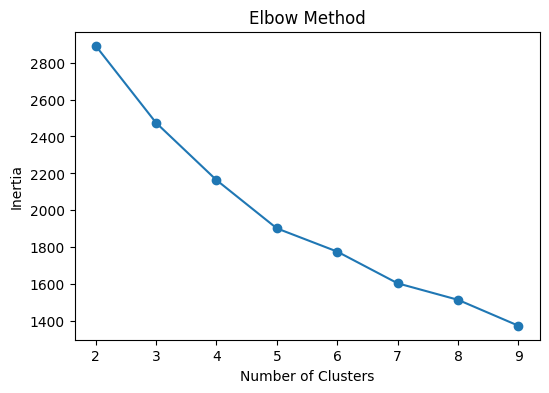

In [103]:
inertia = []

for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_data)
    inertia.append(model.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,10), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [104]:
for k in range(2,10):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")

C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=2, Silhouette Score=0.245
K=3, Silhouette Score=0.216
K=4, Silhouette Score=0.198


C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=5, Silhouette Score=0.203
K=6, Silhouette Score=0.196
K=7, Silhouette Score=0.197
K=8, Silhouette Score=0.193
K=9, Silhouette Score=0.203


C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Although k = 2 achieved the highest silhouette score, selecting four clusters provides more granular behavioral segmentation aligned with the dual-axis structure observed in Milestone 1 PCA analysis. Therefore, k = 4 was retained for interpretability and strategic value.

In [88]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(scaled_data)

C:\Users\rona\.conda\envs\krobus\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


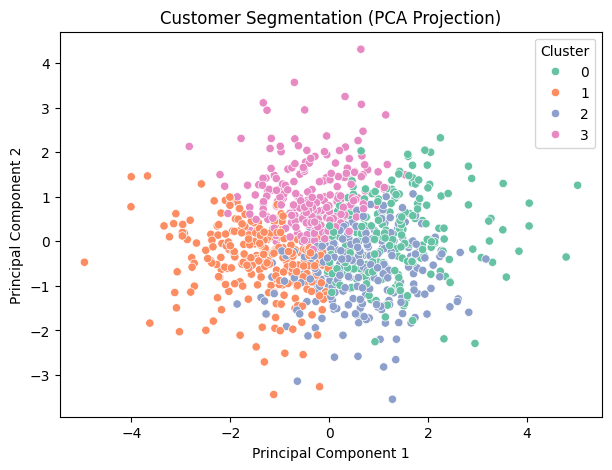

In [89]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_data)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=components[:,0],
    y=components[:,1],
    hue=df_cluster['Cluster'],
    palette='Set2'
)
plt.title("Customer Segmentation (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [90]:
df_cluster['Cluster'].value_counts(normalize=True) * 100

Cluster
1    26.787513
3    25.881168
2    24.974824
0    22.356495
Name: proportion, dtype: float64

In [91]:
cluster_profile = df_cluster.groupby('Cluster')[features].mean()
cluster_profile

,Log_Total_Spending,Transaction_Frequency,Satisfaction_Score,Likelihood_to_Recommend
Cluster,,,,
0,9.954822,7.355856,5.065802,6.429227
1,8.614874,2.969925,4.687669,5.679190
2,9.583530,6.096774,5.713975,3.883814
3,9.221366,4.338521,6.718901,6.337774


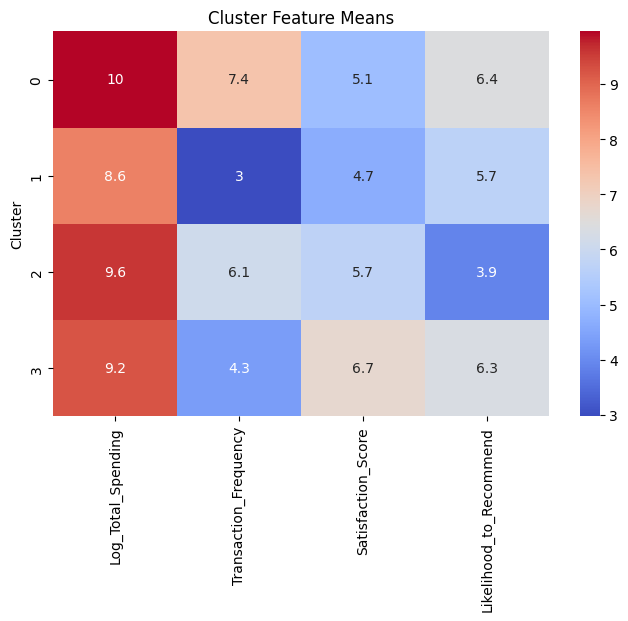

In [92]:
plt.figure(figsize=(8,5))
sns.heatmap(cluster_profile, annot=True, cmap='coolwarm')
plt.title("Cluster Feature Means")
plt.show()

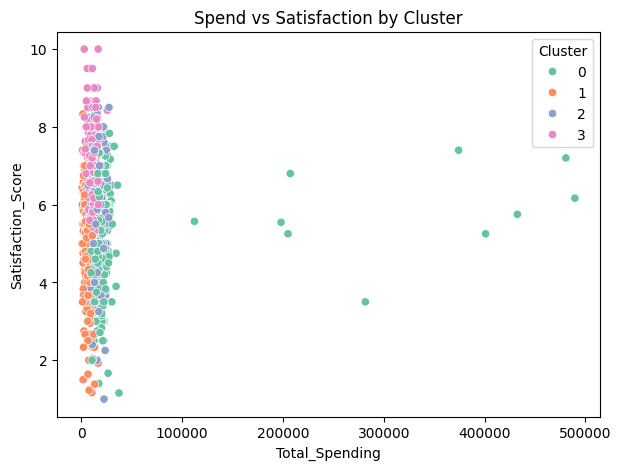

In [93]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_cluster,
    x='Total_Spending',
    y='Satisfaction_Score',
    hue='Cluster',
    palette='Set2'
)
plt.title("Spend vs Satisfaction by Cluster")
plt.show()

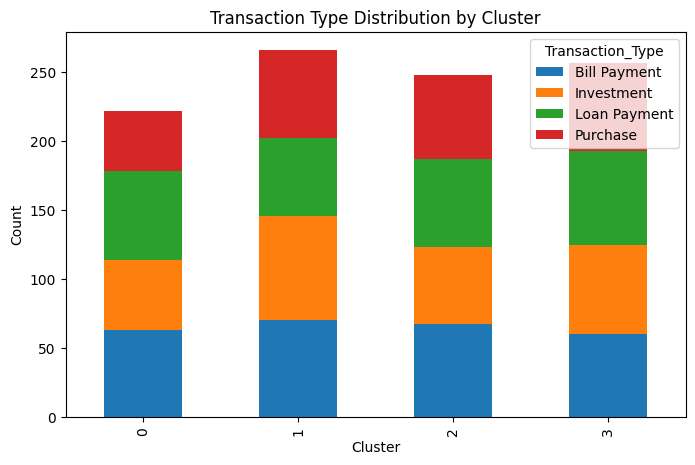

In [94]:
dominant_type = df_transactions.groupby('Customer_ID')['Transaction_Type'] \
    .agg(lambda x: x.value_counts().index[0]) \
    .reset_index()

df_cluster = pd.merge(df_cluster, dominant_type, on='Customer_ID', how='left')

cluster_product = pd.crosstab(df_cluster['Cluster'], df_cluster['Transaction_Type'])

cluster_product.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Transaction Type Distribution by Cluster")
plt.ylabel("Count")
plt.show()